In [ ]:
# need to run this command in order to install librosa 
!pip install llvmlite --ignore-installed


In [1]:
!pip3 install librosa

In [2]:
!pip install tqdm
!pip install scikit-plot

In [10]:
!pip3 install keras
!pip3 install matplotlib
!pip3 install glob

ERROR: Could not find a version that satisfies the requirement glob
ERROR: No matching distribution found for glob


In [11]:
!pip3 install tensorflow

In [19]:
import pandas as pd

# scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight
import scikitplot as skplt


# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical

# Audio
import librosa 
import librosa.display

#Plot
import matplotlib.pyplot as plt

# Utility
import os
from glob import *
import numpy as np
from tqdm import tqdm
import itertools

ImportError: cannot import name 'to_categorical' from 'keras.utils' (C:\Users\simmi\anaconda3\lib\site-packages\keras\utils\__init__.py)

### extract labels from audio files' names

In [25]:
import librosa
import os
import glob
dataset = []
# read all files inside folders sat_a and set_b
for folder in ['./dataset/set_a/**','./dataset/set_b/**']:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            # extracting labels fron file names
            Label = os.path.basename(filename).split('_')[0]
            
            # skip audio smaller than 4 second
            if librosa.get_duration(filename=filename) >= 4:
                if Label not in ['Aunlabelledtest','Bunlabelledtest']:
                    dataset.append({
                        'filename': filename,
                        'label': Label
                    })

dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)

print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404 entries, 70 to 102
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  404 non-null    object
 1   label     404 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB
None


In [29]:
import matplotlib.pyplot as plt

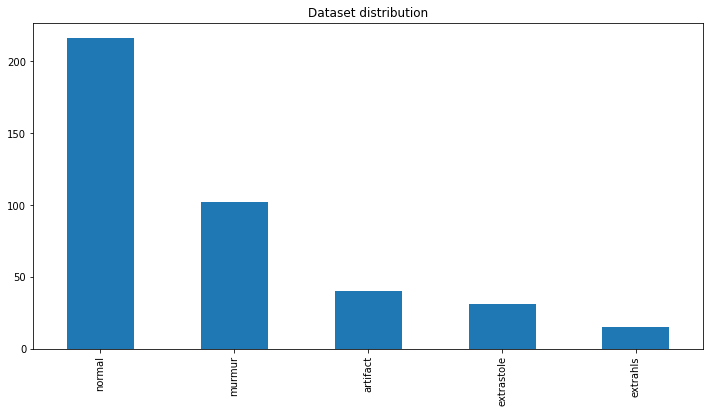

In [30]:
plt.figure(figsize=(12,6))
dataset.label.value_counts().plot(kind='bar', title='Dataset distribution')
plt.show()

In [31]:
#split the dataset into trainig and testing
train, test = train_test_split(dataset, test_size=0.2, random_state=42)
print('Train: %i' %len(train))
print('Test: %i' %len(test))

Train: 323
Test: 81


label:  murmur


AttributeError: module 'librosa' has no attribute 'display'

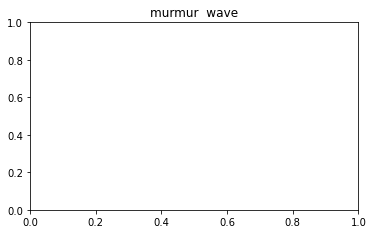

In [32]:
plt.figure(figsize=(20,20))
idx = 0
for label in dataset.label.unique():
    print('label: ', label)
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[0], duration=4)
    # waves
    idx+=1
    plt.subplot(5, 3, idx)
    plt.title('%s  wave' % label)
    librosa.display.waveplot(y, sr=sr)
    # spectogram
    idx+=1
    plt.subplot(5, 3, idx)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, y_axis='linear')
    plt.title('%s spectogram' % label)
    # mfcc
    idx+=1
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    plt.subplot(5, 3, idx)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.title('%s mfcc' % label)
plt.show()

In [33]:
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, duration=4)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfcc

In [36]:
import tqdm
x_train, x_test = [],[]
print('extract features from TRAIN and TEST dataset')
for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx]))
    
for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx]))
    
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

print('x_train: ',x_train.shape)
print('x_test: ',x_test.shape)
#convert labels into numerical values
encoder = LabelEncoder()
encoder.fit(train.label)
y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)



class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train),
                                                   y_train)
#converting the class_weights array into dictionary to use it in model.fit method which requires a dictionary
weights = {i : class_weights[i] for i in range(len(class_weights))}

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
#convert labels in to one hot encoder vectors
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('X train:', x_train.shape)
print('Y train:', y_train.shape)

print('\nX test:', x_test.shape)
print('Y test:', y_test.shape)


extract features from TRAIN and TEST dataset


TypeError: 'module' object is not callable

In [38]:
model = Sequential()
model.add(Conv2D(16, 2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))

model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(32, 2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(64, 2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(128, 2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()



AttributeError: 'list' object has no attribute 'shape'

In [39]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=300,
                    validation_data=(x_test, y_test),
                    class_weight=weights,
                    shuffle=False)
                    
                

NameError: name 'y_train' is not defined

In [ ]:
# Loss curves
plt.figure(figsize=[14,10])
plt.subplot(221)
plt.plot(history.history['loss'], 'r', linewidth=3.0)
plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# accuracy curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
plt.plot(history.history['val_accuracy'], 'b', linewidth=3.0)
plt.legend(['Training accuracy', 'Validation accuracy'], fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show()

In [40]:
# save model and weights
model_name = 'heartbeat_disease.h5'
model.save(model_name)
print('Saved trained model at %s' % model_name)

scores = model.evaluate(x_test, y_test, verbose=1)
print('test loss:', scores[0])
print('test accuracy:', scores[1])

predictions = model.predict(x_test, verbose=1)


y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions):
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
print(classification_report(y_pred, y_true))

ValueError: Weights for model sequential_1 have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.

In [41]:
# Draw Confusion matrix in stylish design

skplt.metrics.plot_confusion_matrix(y_true, y_pred, normalize=False)
plt.xticks(rotation=50)
plt.show()

NameError: name 'y_true' is not defined